## 01_Data_cleaning

### Import necesary libraries

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime, timezone

In [5]:
BASE = '..'
INPUT = os.path.join(BASE, 'data', 'Nova_pay_dataset.csv')
OUTPUT = os.path.join(BASE, 'data', 'Nova_pay_cleaned_dataset.csv')

In [6]:
# Load the dataset

df = pd.read_csv(INPUT)

In [7]:
df.shape

(11400, 26)

### Investigate the data for annomalies and data type

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11400 entries, 0 to 11399
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_id             11400 non-null  object 
 1   customer_id                11400 non-null  object 
 2   timestamp                  11371 non-null  object 
 3   home_country               11400 non-null  object 
 4   source_currency            11400 non-null  object 
 5   dest_currency              11400 non-null  object 
 6   channel                    11400 non-null  object 
 7   amount_src                 11400 non-null  object 
 8   amount_usd                 11095 non-null  float64
 9   fee                        11105 non-null  float64
 10  exchange_rate_src_to_dest  11400 non-null  float64
 11  device_id                  11400 non-null  object 
 12  new_device                 11400 non-null  bool   
 13  ip_address                 11095 non-null  obj

In [15]:
# check for duplicate

df.duplicated().sum()

200

In [17]:
# Investigate missiing values

null_values = df.isnull().sum()
null_values

transaction_id                 0
customer_id                    0
timestamp                     29
home_country                   0
source_currency                0
dest_currency                  0
channel                        0
amount_src                     0
amount_usd                   305
fee                          295
exchange_rate_src_to_dest      0
device_id                      0
new_device                     0
ip_address                   305
ip_country                   302
location_mismatch              0
ip_risk_score                  0
kyc_tier                     302
account_age_days               0
device_trust_score           295
chargeback_history_count       0
risk_score_internal            0
txn_velocity_1h                0
txn_velocity_24h               0
corridor_risk                  0
is_fraud                       0
dtype: int64

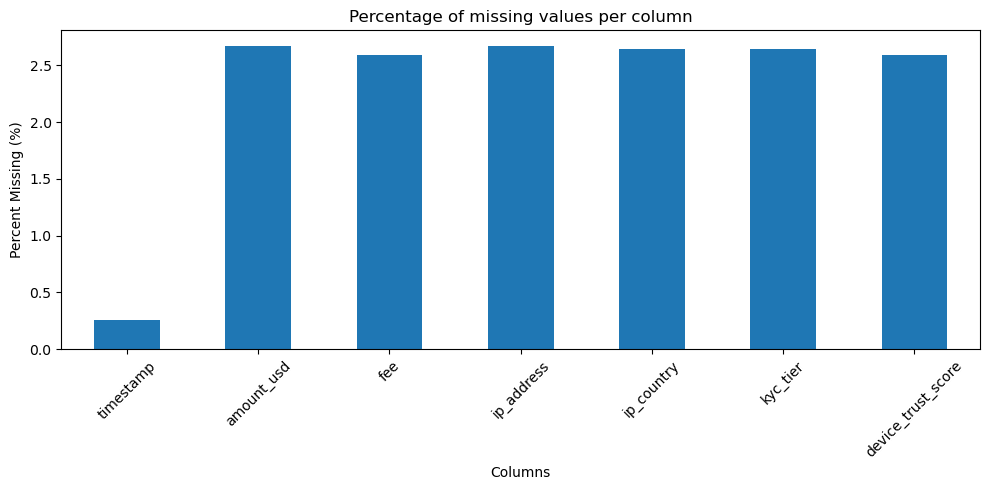

In [19]:
# Bar Plot Showing % of Missing Values per column

missing_percent = df.isnull().mean()*100
missing_percent = missing_percent[missing_percent > 0]

plt.figure(figsize=(10,5))
missing_percent.plot(kind="bar")
plt.title("Percentage of missing values per column")
plt.ylabel("Percent Missing (%)")
plt.xlabel("Columns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# convert amount_src column to float

df['amount_src'] = (df['amount_src'].astype(str).str.replace(',', '', regex=False).astype(float))

In [23]:
def parse_and_validate_timestamps(df:pd.DataFrame, drop_future: bool=True) -> pd.DataFrame:
    if 'timestamp' not in df.columns:
        return df
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
    if drop_future:
        now = pd.Timestamp(datetime.now(tz=timezone.utc))
        df = df[df['timestamp'] <=now]
    return df.dropna(subset=['timestamp'])

df = parse_and_validate_timestamps(df)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11339 entries, 0 to 11399
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   transaction_id             11339 non-null  object             
 1   customer_id                11339 non-null  object             
 2   timestamp                  11339 non-null  datetime64[ns, UTC]
 3   home_country               11339 non-null  object             
 4   source_currency            11339 non-null  object             
 5   dest_currency              11339 non-null  object             
 6   channel                    11339 non-null  object             
 7   amount_src                 11339 non-null  float64            
 8   amount_usd                 11034 non-null  float64            
 9   fee                        11044 non-null  float64            
 10  exchange_rate_src_to_dest  11339 non-null  float64            
 11  device_

### Checking and fixing inconsistency in the data

#### Categorical

In [29]:
categorical = df.select_dtypes(include="object")
categorical.head()

,transaction_id,customer_id,home_country,source_currency,dest_currency,channel,device_id,ip_address,ip_country,kyc_tier
0,fee8542d-8ee6-4b0d-9671-c294dd08ed26,402cccc9-28de-45b3-9af7-cc5302aa1f93,US,USD,CAD,ATM,9f292dcc-3297-4947-a260-6a1ef69041ff,221.78.171.180,US,standard
1,bfdb9fc1-27fe-4a85-b043-4d813d679259,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,CA,CAD,MXN,web,3a95b9f5-309f-4684-a46d-e2ff2435bf78,120.12.20.29,CA,standard
2,fc855034-3ea5-4993-9afa-b511d93fe5e8,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,US,USD,CNY,mobile,a4737752-9aac-43ed-9d8b-2ccdffc24052,223.96.181.93,US,enhanced
3,2cf8c08e-42ec-444d-a755-34b9a2a0a4ca,7bd5200c-5d19-44f0-9afe-8b339a05366b,US,USD,EUR,mobile,6aeb85a3-5603-4221-896c-9e6882764f1a,186.228.15.74,US,standard
4,d907a74d-b426-438d-97eb-dbe911aca91c,70a93d26-8e3a-4179-900c-a4a7a74d08e5,US,USD,INR,mobile,a5b9250e-dbe0-4c5f-a6e7-5492b7349402,11.82.47.62,US,enhanced


In [31]:
exclude = {"transaction_id", "customer_id", "device_id", "ip_address"}

for column in categorical.columns:
    if column not in exclude:
        print(column)
        print(categorical[column].unique())   

home_country
['US' 'CA' 'UK' 'unknown']
source_currency
['USD' 'CAD' 'GBP']
dest_currency
['CAD' 'MXN' 'CNY' 'EUR' 'INR' 'GBP' 'PHP' 'NGN' 'USD']
channel
['ATM' 'web' 'mobile' 'WEB' 'MOBILE' 'mobille' 'unknown' 'weeb' 'ATm']
ip_country
['US' 'CA' nan 'UK' 'NAN' 'unknown']
kyc_tier
['standard' 'enhanced' 'low' nan 'standrd' 'STANDARD' 'NAN' 'unknown'
 'enhancd' 'ENHANCED' 'LOW']


In [33]:
def fix_channel(x):
    mapping = {
        "MOBILE": "mobile", 
        "ATm": "ATM", 
        "mobille": "mobile",
        "WEB": "web", 
        "weeb": "web", 
    }
    return mapping.get(x, x)

def fix_ip_country(x):
    mapping = {
        "nan": np.nan,
        "NAN": np.nan,
        "unknown": np.nan
    }
    return mapping.get(x, x)

def fix_kyc_tier(x):
    mapping = {
        "standrd": "standard",
        "STANDARD": "standard",
        "nan": np.nan,
        "NAN": np.nan,
        "unknown": np.nan,
        "enhancd": "enhanced",
        "ENHANCED": "enhanced",
        "LOW": "low"
    }
    return mapping.get(x,x)


In [35]:
df["kyc_tier"] = df["kyc_tier"].apply(fix_kyc_tier)
df["ip_country"] = df["ip_country"].apply(fix_ip_country)
df["channel"] = df["channel"].apply(fix_channel)

#### Numerical

In [39]:
def fix_ranges(df: pd.DataFrame) -> pd.DataFrame:

    monetory_cols = ['amount_src', 'amount_usd', 'fee']
    score_cols = ['ip_risk_score', 'device_trust_score', 'risk_score_internal', 'corridor_risk']
    velocity_cols = ['txn_velocity_1h', 'txn_velocity_24h']

    for col in monetory_cols:
        if col in df.columns:
            if df[col].dtype == 'object':
                df[col] = (df[col].astype(str).str.replace(',', '', regex=False))
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df.loc[df[col] < 0, col] = np.nan

    for col in score_cols:
        if col in df.columns:
            df[col] = df[col].clip(lower=0, upper=1)

    for col in velocity_cols:
        if col in df.columns:
            df[col] = df[col].clip(lower=0)

    return df

In [41]:
# Fill in missing values

def minimal_impute(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Numeric with median
    if 'fee' in df.columns:
        df['fee'] = df['fee'].fillna(df['fee'].median())
    if 'amount_usd' in df.columns:
        df['amount_usd'] = df['amount_usd'].fillna(df['amount_usd'].median())
    if 'amount_src' in df.columns:
        df['amount_src'] = df['amount_src'].fillna(df['amount_src'].median())
    if 'device_trust_score' in df.columns:
        df['device_trust_score'] = df['device_trust_score'].fillna(df['device_trust_score'].median())
    if 'ip_risk_score' in df.columns:
        df['ip_risk_score'] = df['ip_risk_score'].fillna(df['ip_risk_score'].median())

    # Categorical
    if 'kyc_tier' in df.columns:
        df['kyc_tier'] = df['kyc_tier'].apply(fix_kyc_tier)
        df['kyc_tier'] = df['kyc_tier'].fillna('standard')
    if 'ip_address' in df.columns:
        df['ip_address'] = df['ip_address'].fillna('unknown')
        
    # Timestamp
    if 'timestamp' in df.columns:
        df = df.sort_values(['customer_id', 'timestamp'])
        df['timestamp'] = df.groupby('customer_id')['timestamp'].ffill()
        
    # Countries
    if 'ip_country' in df.columns and 'home_country' in df.columns:
        # Flag missing IP country
        df['ip_country_missing'] = df['ip_country'].isna()
        # Then fill missing IP country using hopme country
        df['ip_country'] = df['ip_country'].fillna(df['home_country'])

    return df

df = minimal_impute(df).reset_index(drop=True)

In [43]:
# Drop duplicate in transaction_id column - ensures transaction id id unque to each transaction

def drop_dupes(df: pd.DataFrame, id_col: str = 'transaction_id') -> pd.DataFrame:
    if id_col in df.columns:
        df = df.drop_duplicates(subset=[id_col], keep='first')
    else:
        df = df.drop_duplicates(keep='first')
    return df

df = drop_dupes(df).reset_index(drop=True)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11140 entries, 0 to 11139
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   transaction_id             11140 non-null  object             
 1   customer_id                11140 non-null  object             
 2   timestamp                  11140 non-null  datetime64[ns, UTC]
 3   home_country               11140 non-null  object             
 4   source_currency            11140 non-null  object             
 5   dest_currency              11140 non-null  object             
 6   channel                    11140 non-null  object             
 7   amount_src                 11140 non-null  float64            
 8   amount_usd                 11140 non-null  float64            
 9   fee                        11140 non-null  float64            
 10  exchange_rate_src_to_dest  11140 non-null  float64            
 11  de

In [47]:
df.head()

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud,ip_country_missing
0,dcd64b56-3092-4778-a0ce-207d76b282d9,0006f893-10a8-4235-831b-fcae1e3f0140,2023-12-24 15:43:45.573611+00:00,CA,CAD,PHP,web,729.85,540.09,12.06,...,standard,17,0.182,0,0.566,6,9,0.00,1,False
1,9ddaf713-8129-44bb-9873-11b1bd5a9228,00147b79-11ed-4f8f-a3af-651778b78dd3,2024-04-12 02:12:31.573611+00:00,US,USD,MXN,web,286.04,286.04,5.88,...,low,46,0.169,0,0.852,5,6,0.20,1,False
2,77c581e1-7e9c-4a5b-bd6a-6649e927d8ca,00668d83-6f9f-4401-9a0f-04f94140abb6,2025-10-15 14:02:56.573611+00:00,US,USD,USD,mobile,99.21,99.21,2.44,...,enhanced,1095,0.947,0,0.265,0,1,0.00,0,False
3,fee6f817-6d89-4d70-b634-f088214ff99a,00957a15-945f-4bfb-b5fc-d867cbaee95d,2024-07-14 22:19:08.573611+00:00,UK,GBP,NGN,mobile,2184.73,2730.91,34.15,...,low,36,0.369,0,0.488,7,10,0.22,1,False
4,a74a6887-3935-42b1-a67a-7e5f61b21087,00ab675d-a6ea-4d6e-bcdf-79027ce4f944,2024-07-13 09:52:36.573611+00:00,US,USD,PHP,mobile,146.36,146.36,4.07,...,standard,90,0.761,0,0.133,0,2,0.00,0,False


In [49]:
# Save clean data


df = pd.read_csv(INPUT)

df = parse_and_validate_timestamps(df)
df = fix_ranges(df)
df = drop_dupes(df)
df = minimal_impute(df)

# Apply value fix function "per column"
df["channel"] = df["channel"].apply(fix_channel)

print(df.shape)
df.to_csv(OUTPUT, index=False)
print('Saved to', OUTPUT)

(11140, 27)
Saved to ..\data\Nova_pay_cleaned_dataset.csv


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11140 entries, 10232 to 10412
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   transaction_id             11140 non-null  object             
 1   customer_id                11140 non-null  object             
 2   timestamp                  11140 non-null  datetime64[ns, UTC]
 3   home_country               11140 non-null  object             
 4   source_currency            11140 non-null  object             
 5   dest_currency              11140 non-null  object             
 6   channel                    11140 non-null  object             
 7   amount_src                 11140 non-null  float64            
 8   amount_usd                 11140 non-null  float64            
 9   fee                        11140 non-null  float64            
 10  exchange_rate_src_to_dest  11140 non-null  float64            
 11  dev